# Analysis of model performances on pre/post ambiguity gridsearch

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.stats import mannwhitneyu

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
grid_dict = {}
grid_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/'
for folder in os.listdir(grid_dir):
    if 'n_' in folder:
        if os.path.isfile(os.path.join(grid_dir, folder, 'results_test.json')):
            n = re.search('n_([\d]{1,3})', folder).group(1)
            kl = re.search('kl_([\d]{1,2})', folder).group(1)
            with open(os.path.join(grid_dir, folder, 'results_test.json'), 'r') as f:
                grid_dict[(int(n), int(kl))] = json.load(f)

In [3]:
n_list = [list(grid_dict.keys())[k][0] for k in range(len(grid_dict))]
kl_list = [list(grid_dict.keys())[k][1] for k in range(len(grid_dict))]
loss = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['final_loss_val'][0] for i in range(len(grid_dict))]
gb = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['gb_pre'] for i in range(len(grid_dict))]
logreg = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['logreg_pre'] for i in range(len(grid_dict))]
svm = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['svm_pre'] for i in range(len(grid_dict))]

In [4]:
grid_df = pd.DataFrame(list(zip(n_list, kl_list, loss, gb, logreg, svm)), columns=['n', 'kl', 'loss', 'gb','logreg', 'svm'])

In [5]:
grid_df['mean_classif'] = list((grid_df.gb + grid_df.logreg + grid_df.svm)/3)

In [6]:
grid_df.sort_values(by=['mean_classif', 'loss'], ascending=[False, True])

,n,kl,loss,gb,logreg,svm,mean_classif
17,100,4,17165.892904,0.948508,1.000000,1.000000,0.982836
26,50,8,20551.902483,0.948456,0.989553,1.000000,0.979336
12,150,4,16777.611485,0.937996,1.000000,1.000000,0.979332
9,150,10,21133.906901,0.929105,0.989861,0.979608,0.966191
13,50,2,16829.031331,0.898495,1.000000,1.000000,0.966165
22,100,2,14761.479713,0.928027,0.979452,0.979452,0.962310
8,100,8,20207.614037,0.896863,0.989899,1.000000,0.962254
21,20,8,21073.405285,0.918561,0.969603,0.969603,0.952589
24,20,4,20148.578590,0.949476,0.968882,0.938317,0.952225
27,100,10,21529.536063,0.876713,1.000000,0.969313,0.948675


In [7]:
grid_df[['n', 'kl', 'loss', 'logreg']].sort_values(by=['logreg', 'loss'], ascending=[False, True])

,n,kl,loss,logreg
19,75,2,15431.062837,1.000000
12,150,4,16777.611485,1.000000
13,50,2,16829.031331,1.000000
17,100,4,17165.892904,1.000000
27,100,10,21529.536063,1.000000
8,100,8,20207.614037,0.989899
16,150,8,20450.873047,0.989899
6,40,2,17456.866269,0.989880
25,40,8,20816.982306,0.989861
14,75,10,21088.715030,0.989861


#### Model choice
...

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
model_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/n_75_kl_2/checkpoint.pt'
#model_dir = '/neurospin/dico/lguillon/distmap/checkpoint.pt'
model = VAE((1, 80, 80, 96), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Data

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = "/neurospin/dico/lguillon/distmap/data/"

test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

In [10]:
# data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rdistmaps"
# tgt_dir = '/neurospin/dico/lguillon/distmap/data'

# list_sample_id = []
# list_sample_file = []

# for sub in tqdm(test_list.subjects):
#     distmap = os.path.join(data_dir, f"{sub}_cropped_distmap.nii.gz")
#     vol = aims.read(distmap)
#     sample = np.asarray(vol)
#     list_sample_id.append(sub)
#     list_sample_file.append(sample)

# list_sample_id = np.array(list_sample_id)
# list_sample_file = np.array(list_sample_file)
# np.save(os.path.join(tgt_dir, 'test_sub_id.npy'), list_sample_id)
# np.save(os.path.join(tgt_dir, 'test_distmap.npy'), list_sample_file)
# print("test set saved !")

In [5]:
data_dir = "/neurospin/dico/lguillon/distmap/data/"

distmaps = np.load(os.path.join(data_dir, "test_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "test_sub_id.npy"))

print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)

testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=8,
               num_workers=8,
               shuffle=False) 

(200, 78, 63, 88, 1) (200,)


##### SC int
[111009, 138231, 510225, 199251, 159946, 140319, 212419] 

In [6]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_arr = np.array(['111009', '138231', '510225', '199251', '159946', '140319', '212419'])

data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rdistmaps"

distmaps_scint = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_scint = np.load(os.path.join(data_dir, "sub_id.npy"))

ids = np.frompyfunc(lambda x: np.isin(x, scint_arr), 1, 1)(filenames_scint)
idxs = [i for i, curr in enumerate(ids) if curr.any()]

filenames_scint = filenames_scint[idxs]
distmaps_scint = distmaps_scint[idxs]

print(distmaps_scint.shape, filenames_scint.shape)

subset_scint = SkeletonDataset(dataframe=distmaps_scint,
                         filenames=filenames_scint,
                         data_transforms=False)

scint_loader = torch.utils.data.DataLoader(
               subset_scint,
               batch_size=1,
               num_workers=1,
               shuffle=False) 

(7, 78, 63, 88, 1) (7,)


In [7]:
dico_set_loaders_hcp = {'hcp': testloader, 'scint': scint_loader}

root_dir = '/neurospin/dico/lguillon/distmap/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

In [8]:
results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}

df_encoded_hcp = pd.DataFrame()
df_encoded_hcp['latent'] = encoded_hcp['hcp'] + encoded_hcp['scint'] 
df_encoded_hcp['Group'] = ['hcp' for k in range(len(filenames))] + ['scint' for k in range(len(filenames_scint))]

hcp


KeyboardInterrupt: 

### Analysis of latent space

#### Reduced space - TSNE / UMAP

In [10]:
X_hcp = np.array(list(df_encoded_hcp['latent']))
labels_hcp = np.array(df_encoded_hcp['Group'])

from sklearn.manifold import TSNE
X_embedded_hcp = TSNE(n_components=2, random_state=12, perplexity=40).fit_transform(X_hcp)

In [11]:
subjects_name_hcp = ['' for k in filenames] + scint_list 

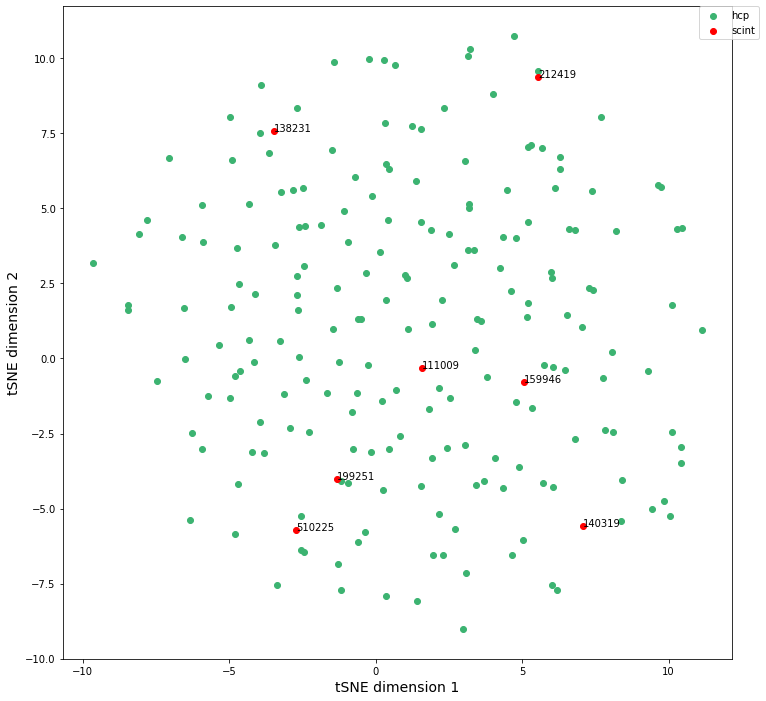

In [12]:
arr = X_embedded_hcp
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

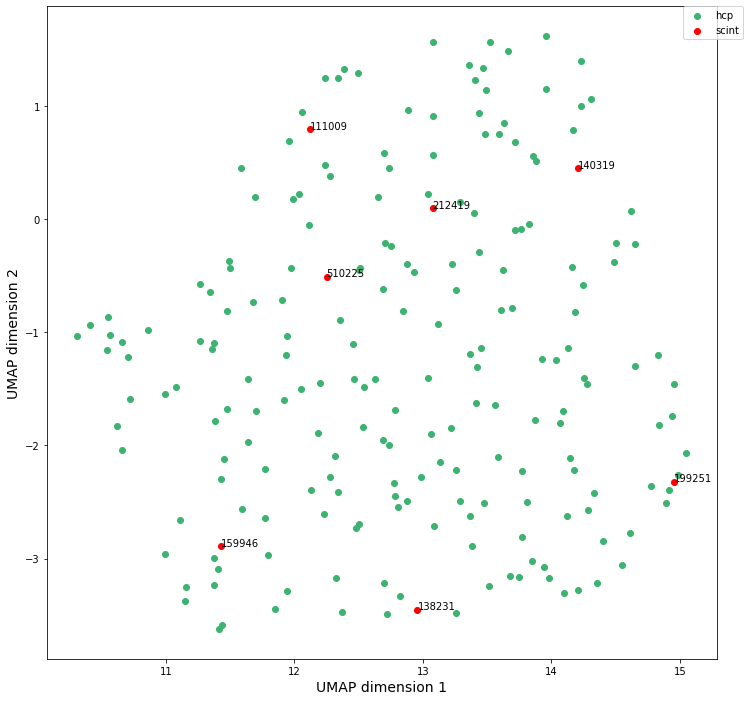

In [12]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Outlier detection ML algorithm

In [13]:
""" OCSVM """
clf = OneClassSVM(nu=0.25).fit(X_embedded)
clf.predict(X_embedded)

array([-1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
        1, -1, -1])

In [14]:
clf = LocalOutlierFactor()
clf.fit_predict(X_embedded)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
clf = IsolationForest(random_state=10, contamination=0.1).fit(embedding)
clf.predict(embedding)

array([-1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,
        1,  1,  1])

No outlier is detected, except with OCSVM which seems rather random

### Classifiers

In [65]:
""" Benchmark data """
filenames = np.load(os.path.join('/neurospin/dico/lguillon/distmap/data', "train_sub_id.npy"))

# Precentral
b_dir_pre = '/neurospin/dico/data/deep_folding/current/' \
                        'datasets/hcp/crops/1mm/precentral/no_mask/benchmark/'

df = pd.read_csv("/neurospin/dico/lguillon/distmap/" \
                     "pre_post_ambiguity_search/subject_pre.csv")
train_list = np.array(list(df.subjects))

distmaps = np.load(os.path.join(b_dir_pre, "distmap_1mm.npy"),
                   mmap_mode='r')

sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, train_list, sorter=sorter)]
filenames = filenames[filenames_idx]
distmaps = distmaps[filenames_idx]

print(distmaps.shape, filenames.shape)

benchmark_pre = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                             data_transforms=False)
# Postcentral
filenames = np.load(os.path.join('/neurospin/dico/lguillon/distmap/data', "train_sub_id.npy"))

b_dir_post = '/neurospin/dico/data/deep_folding/current/' \
                        'datasets/hcp/crops/1mm/postcentral/no_mask/benchmark'

df = pd.read_csv("/neurospin/dico/lguillon/distmap/" \
                     "pre_post_ambiguity_search/subject_post.csv")
train_list = np.array(list(df.subjects))

distmaps = np.load(os.path.join(b_dir_post, "distmap_1mm.npy"),
                   mmap_mode='r')

sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, train_list, sorter=sorter)]
filenames = filenames[filenames_idx]
distmaps = distmaps[filenames_idx]

print(distmaps.shape, filenames.shape)

benchmark_post = SkeletonDataset(dataframe=distmaps,
                                 filenames=filenames,
                                 data_transforms=False)

benchloader_pre = torch.utils.data.DataLoader(
                  benchmark_pre,
                  batch_size=1,
                  num_workers=8,
                  shuffle=False)
benchloader_post = torch.utils.data.DataLoader(
                   benchmark_post,
                   batch_size=1,
                   num_workers=8,
                   shuffle=False)

(29, 78, 63, 88, 1) (29,)
(23, 78, 63, 88, 1) (23,)


In [67]:
dico_set_loaders = {'hcp': testloader, 'scint': scint_loader, 'pre': benchloader_pre, 'post': benchloader_post}

tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=4,
                     n_latent=100, depth=3)

results_classif = tester.test()
encoded_classif = {loader_name:[results_classif[loader_name][k][1] for k in results_classif[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_classif = {loader_name:[int(results_classif[loader_name][k][0].cpu().detach().numpy()) for k in results_classif[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

df_encoded_classif = pd.DataFrame()
df_encoded_classif['latent'] = encoded_classif['hcp'] + encoded_classif['scint'] + encoded_classif['pre'] + encoded_classif['post']
df_encoded_classif['Group'] = ['hcp' for k in range(200)] + ['scint' for k in range(len(filenames_scint))] + ['pre' for k in range(len(benchmark_pre))] + ['post' for k in range(len(benchmark_post))]


hcp
scint
pre
post


In [68]:
X_classif = np.array(encoded_classif['hcp'] + encoded_classif['pre'] + encoded_classif['post'])
label_classif = np.array([0 for k in range(200)] + [1 for k in range(52)])

In [69]:
skf = StratifiedKFold(n_splits=3)
av_log, av_svm, av_gb = [], [], []
for train, test in skf.split(X_classif, label_classif):
    clf = LogisticRegression(random_state=0).fit(X_classif[train], label_classif[train])
    pred = clf.predict(X_classif[test])
    print(f1_score(label_classif[test], pred, average='weighted'))

0.9879589546256213
1.0
1.0


In [70]:
clf.predict(encoded_classif['scint'])

array([0, 0, 0, 0, 0, 0, 0])

### Clusters ? 
how is the latent space organized ? 

For n_clusters = 2 The average silhouette_score with kmeans is : 0.35911423
For n_clusters = 3 The average silhouette_score with kmeans is : 0.38117805
For n_clusters = 4 The average silhouette_score with kmeans is : 0.38439742
For n_clusters = 5 The average silhouette_score with kmeans is : 0.3552802
For n_clusters = 6 The average silhouette_score with kmeans is : 0.3453667
For n_clusters = 7 The average silhouette_score with kmeans is : 0.3507454
For n_clusters = 8 The average silhouette_score with kmeans is : 0.34320173
For n_clusters = 9 The average silhouette_score with kmeans is : 0.34051073
For n_clusters = 10 The average silhouette_score with kmeans is : 0.3538955
For n_clusters = 11 The average silhouette_score with kmeans is : 0.33900076
For n_clusters = 12 The average silhouette_score with kmeans is : 0.33585566
For n_clusters = 13 The average silhouette_score with kmeans is : 0.33586195
For n_clusters = 14 The average silhouette_score with kmeans is : 0.32742882
For n_clust

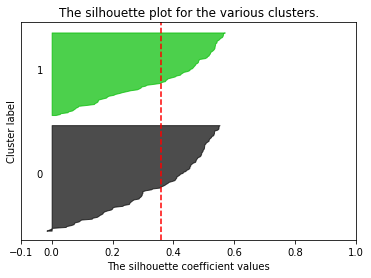

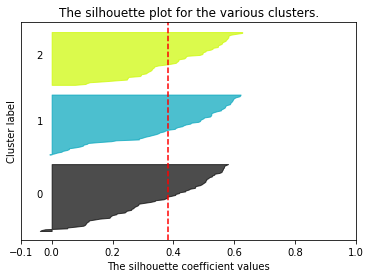

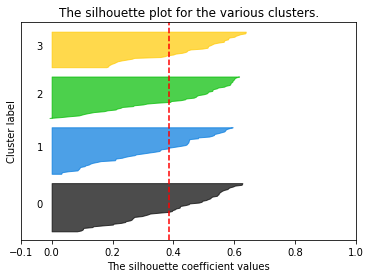

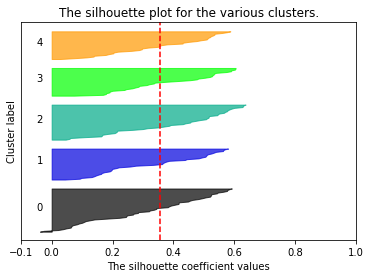

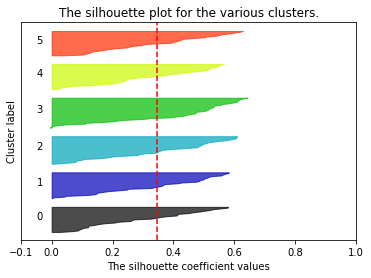

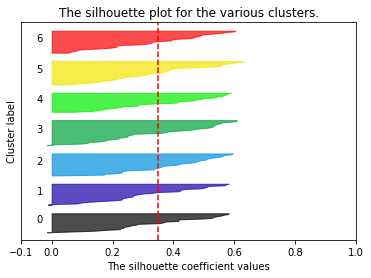

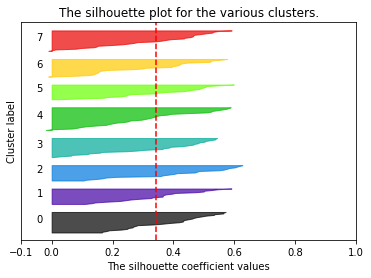

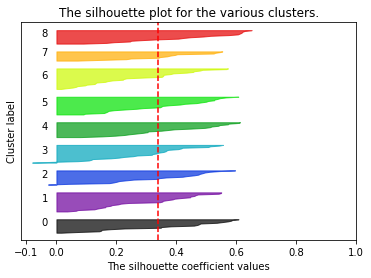

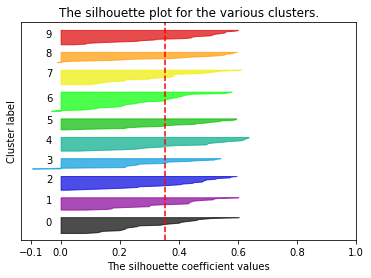

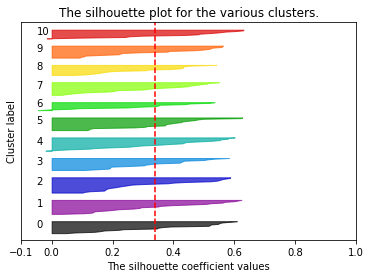

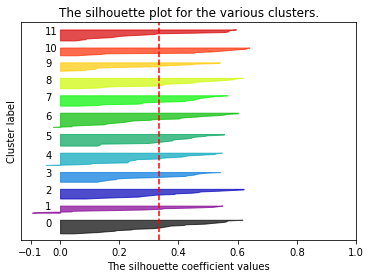

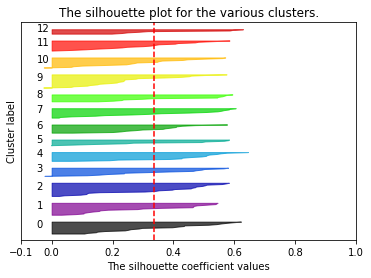

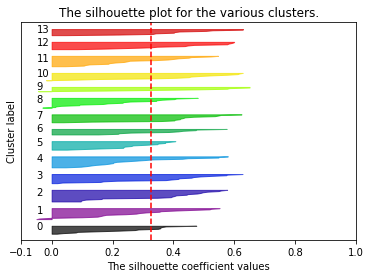

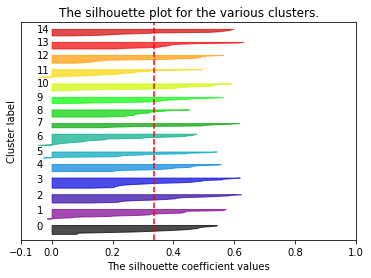

In [151]:
n_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n in n_clusters_list:
    cluster_labels= KMeans(n_clusters=n, random_state=0).fit_predict(X_embedded)

    fig, ax1 = plt.subplots()
    ax1.set_ylim([0, len(X) + (n + 1) * 10])
    silhouette_avg = silhouette_score(X_embedded, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score with kmeans is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_embedded, cluster_labels)

    y_lower = 10
    for i in range(n):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

No clusters

### Distances to centroid

In [152]:
def centeroidnp(arr):
    length, dim = arr.shape
    return np.array([np.sum(arr[:, i])/length for i in range(dim)])

In [153]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [154]:
sub = {loader_name:np.array([int(k) for k in results[loader_name].keys()]) for loader_name in dico_set_loaders.keys()}
sub_id = list(sub['hcp']) + list(sub['scint'])

In [155]:
dstrb_sub = pd.DataFrame(X, index=sub_id, columns=[k for k in range(1, len(df_encoded.latent[0])+1)])

In [156]:
dstrb_sub.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
932554,0.709398,0.695751,1.252142,-0.220239,0.096666,0.134514,-2.199713,-1.095104,0.851359,-2.195184,...,-0.817401,2.001332,-1.301258,0.823624,0.377621,-1.152502,0.239353,2.456108,1.789477,-0.541227
387959,0.299711,1.071009,-0.080288,0.921001,-0.886673,-0.913734,1.054288,-1.463712,-1.902361,0.818629,...,-0.337084,-0.899465,-0.827361,1.996690,-0.494872,0.358611,2.339357,1.739197,-2.250903,-0.182036
887373,1.419120,-0.188266,-0.647444,1.476163,-2.336589,0.829363,1.267216,-1.723138,0.438238,0.449499,...,1.951562,1.310674,-1.314285,2.048494,-2.172611,-0.166414,1.138702,2.691492,2.466863,-1.898701
704238,-0.996836,0.175932,1.185129,-0.098586,-0.273047,1.602606,-0.592880,-0.594025,-0.159533,-0.338760,...,-1.100715,-0.467226,0.066285,0.855985,-1.226239,-0.448801,0.051291,2.400140,-2.435829,-0.423721
169040,0.434011,-0.226302,0.580177,-1.796409,-1.002934,-0.008331,0.287807,-2.529592,-0.620692,-1.567166,...,0.330114,-1.391813,-3.041251,0.765775,1.138345,-0.645252,0.426980,1.768257,-0.540084,0.119288


In [157]:
centroid = closest_distance(centeroidnp(X), dstrb_sub)
print(centroid)

180937


In [158]:
dist_centroid_ctrl = [distance.cityblock(encoded['hcp'][k], centroid) for k in range(len(encoded['hcp']))]
dist_centroid_scint = [distance.cityblock(encoded['scint'][k], centroid) for k in range(len(encoded['scint']))]

In [159]:
F,p = mannwhitneyu(dist_centroid_ctrl, dist_centroid_scint)
print(p)

0.12460227158915005


In [160]:
""" In reduced space """
dstrb_sub_red = pd.DataFrame(X_embedded, index=sub_id, columns=[1, 2])
centroid_red = closest_distance(centeroidnp(X_embedded), dstrb_sub_red)
print(centroid_red)
dist_centroid_ctrl_red = [distance.cityblock(X_embedded[k], centroid_red) for k in range(len(encoded['hcp']))]
dist_centroid_scint_red = [distance.cityblock(X_embedded[200+k], centroid_red) for k in range(len(encoded['scint']))]
F,p = mannwhitneyu(dist_centroid_ctrl_red, dist_centroid_scint_red)
print(p)

152831
0.3441316692609492


In [161]:
centroid_red

152831

### On Reconstructions

#### Loss distribution

(array([2., 0., 1., 1., 0., 1., 0., 0., 0., 2.]),
 array([2425., 2529., 2633., 2737., 2841., 2945., 3049., 3153., 3257.,
        3361., 3465.]),
 <BarContainer object of 10 artists>)

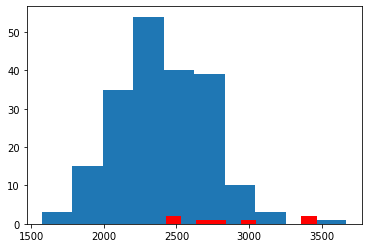

In [162]:
plt.subplot()
plt.hist(losses['hcp'])
plt.hist(losses['scint'], color='r')

In [163]:
F,p = mannwhitneyu(losses['hcp'], losses['scint'])
print(p)

0.0021843786480640927


#### Reconstruction Error

In [164]:
recon = {loader_name:[int(results[loader_name][k][2].cpu().detach().numpy()) for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

(array([2., 0., 1., 1., 0., 1., 0., 0., 0., 2.]),
 array([1981. , 2086.4, 2191.8, 2297.2, 2402.6, 2508. , 2613.4, 2718.8,
        2824.2, 2929.6, 3035. ]),
 <BarContainer object of 10 artists>)

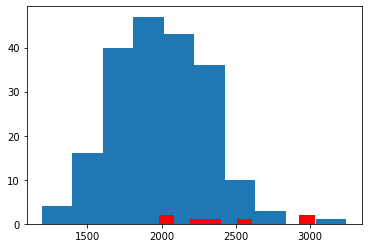

In [165]:
plt.subplot()
plt.hist(recon['hcp'])
plt.hist(recon['scint'], color='r')

In [166]:
F,p = mannwhitneyu(recon['hcp'], recon['scint'])
print(p)

0.002206484879014046


##### Reconstruction of central subject

In [58]:
input = {loader_name:[results[loader_name][k][3].cpu().detach().numpy() for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [69]:
k_centroid = int(np.where(sub['hcp']==centroid_red)[0])

enc = encoded['hcp'][k_centroid]

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

In [70]:
error_map = input['hcp'][k_centroid] - out

In [71]:
np.save(f"/volatile/out_1.npy", out)
np.save('/volatile/input_1.npy', input['hcp'][k_centroid])
np.save('/volatile/error_1.npy', error_map)

In [40]:
arr_out = []
arr_in = []
arr_error = []

for k in range(7):
    enc = encoded['scint'][k]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    arr_out.append(out)
    arr_in.append(input['scint'][k])
    arr_error.append(input['scint'][k] - out)

In [41]:
np.save(f"/volatile/out_int.npy", arr_out)
np.save('/volatile/input_int.npy', arr_in)
np.save('/volatile/error_int.npy', arr_error)

### Application on on-handed subjects

In [73]:
labels = pd.read_csv('/neurospin/dico/lguillon/ohbm_22/one_handed_labels.csv')
labels.head()

,SubjID,Gender,Age at time of scan,Age at limb loss,Group,Amp. Side,Dominant hand
0,PA01,M,57,20.0,AMP,L,NaN
1,PA02,F,49,0.0,CONG,L,NaN
2,PA03,M,59,40.0,AMP,L,NaN
3,PA04,F,52,0.0,CONG,R,NaN
4,PA05,M,58,27.0,AMP,L,NaN


In [74]:
ctrl = labels[labels['Dominant hand']=='R']
one_handed = labels[labels['Group']!='CTR']
one_handed = labels[labels['Amp. Side']=='L']

amputee = one_handed[one_handed['Group']=='AMP']
cong = one_handed[one_handed['Group']=='CONG']

print(len(ctrl))

16


In [77]:
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/one_handed/crops/SC/no_mask/Rdistmaps/"

distmaps_ctrl = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_ctrl = np.load(os.path.join(data_dir, "sub_id.npy"))

distmaps_amputee = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_amputee = np.load(os.path.join(data_dir, "sub_id.npy"))

distmaps_cong = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_cong = np.load(os.path.join(data_dir, "sub_id.npy"))

In [78]:
ctrl_list = np.array(list(ctrl.SubjID))
sorter = np.argsort(filenames_ctrl)
filenames_idx = sorter[np.searchsorted(filenames_ctrl, ctrl_list, sorter=sorter)]
filenames_ctrl = filenames_ctrl[filenames_idx]
distmaps_ctrl = distmaps_ctrl[filenames_idx]

amputee_list = np.array(list(amputee.SubjID))
sorter = np.argsort(filenames_amputee)
filenames_idx = sorter[np.searchsorted(filenames_amputee, amputee_list, sorter=sorter)]
filenames_amputee = filenames_amputee[filenames_idx]
distmaps_amputee = distmaps_amputee[filenames_idx]

cong_list = np.array(list(cong.SubjID))
sorter = np.argsort(filenames_cong)
filenames_idx = sorter[np.searchsorted(filenames_cong, cong_list, sorter=sorter)]
filenames_cong = filenames_cong[filenames_idx]
distmaps_cong = distmaps_cong[filenames_idx]

In [224]:
subset_ctrl = SkeletonDataset(dataframe=distmaps_ctrl,
                         filenames=filenames_ctrl,
                         data_transforms=False)

ctrl_loader = torch.utils.data.DataLoader(
               subset_ctrl,
               batch_size=1,
               num_workers=1,
               shuffle=False) 

subset_amputee = SkeletonDataset(dataframe=distmaps_amputee,
                         filenames=filenames_amputee,
                         data_transforms=False)

amputee_loader = torch.utils.data.DataLoader(
               subset_amputee,
               batch_size=1,
               num_workers=1,
               shuffle=False) 

subset_cong = SkeletonDataset(dataframe=distmaps_cong,
                         filenames=filenames_acong,
                         data_transforms=False)

cong_loader = torch.utils.data.DataLoader(
               subset_cong,
               batch_size=1,
               num_workers=1,
               shuffle=False) 

dico_set_loaders = {'ctrl': ctrl_loader, 'amputee': amputee_loader, 'congenital': cong_loader}

In [225]:
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=4,
                     n_latent=100, depth=3)

results_oh = tester.test()

losses_oh = {loader_name:[int(results_oh[loader_name][k][0].cpu().detach().numpy()) for k in results_oh[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
encoded_oh = {loader_name:[results_oh[loader_name][k][1] for k in results_oh[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

ctrl


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f54b95e7908>>
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5557d025f8>>
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shu

amputee


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f54b95e7908>>
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5557d025f8>>
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shu

congenital


In [227]:
df_encoded_oh = pd.DataFrame()

df_encoded_oh['latent'] = encoded_oh['ctrl'] + encoded_oh['amputee'] + encoded_oh['congenital']

df_encoded_oh['Group'] = ['ctrl' for k in range(len(losses_oh['ctrl']))] + ['amputee' for k in range(len(losses_oh['amputee']))] +['congenital'for k in range(len(losses_oh['congenital']))]

X_hand = np.array(list(df_encoded_oh['latent']))
label_hand = np.array(df_encoded_oh['Group'])

subjects_name = list(filenames_ctrl) + list(filenames_amputee) + list(filenames_cong)

In [228]:
X_oh = np.array(list(df_encoded_oh['latent']))
labels_oh = np.array(df_encoded_oh['Group'])

X_embedded_oh = TSNE(n_components=2, random_state=12, perplexity=25).fit_transform(X_oh)

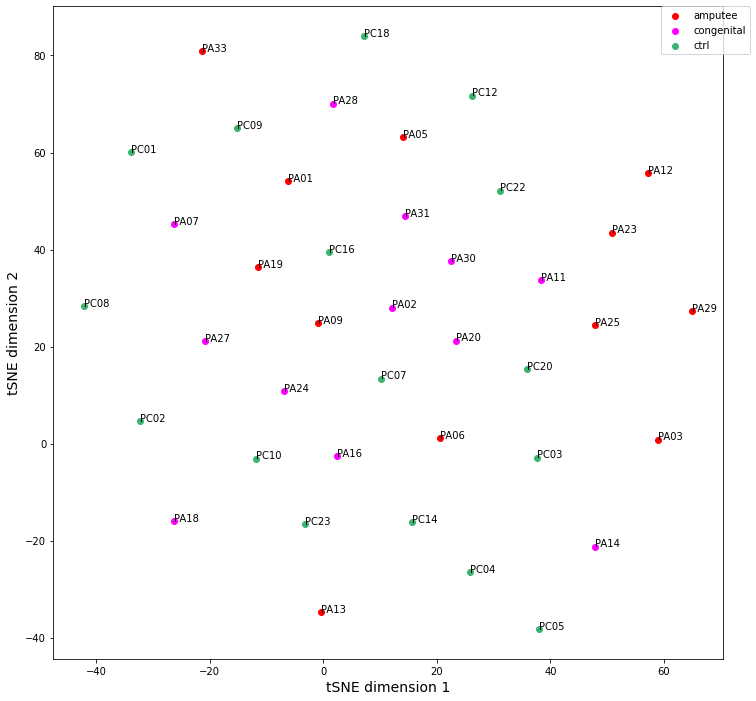

In [229]:
arr = X_embedded_oh
color_dict = {'ctrl':'mediumseagreen', 'amputee': 'red', 'congenital':'magenta'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels_oh):
    ix = np.where(labels_oh == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

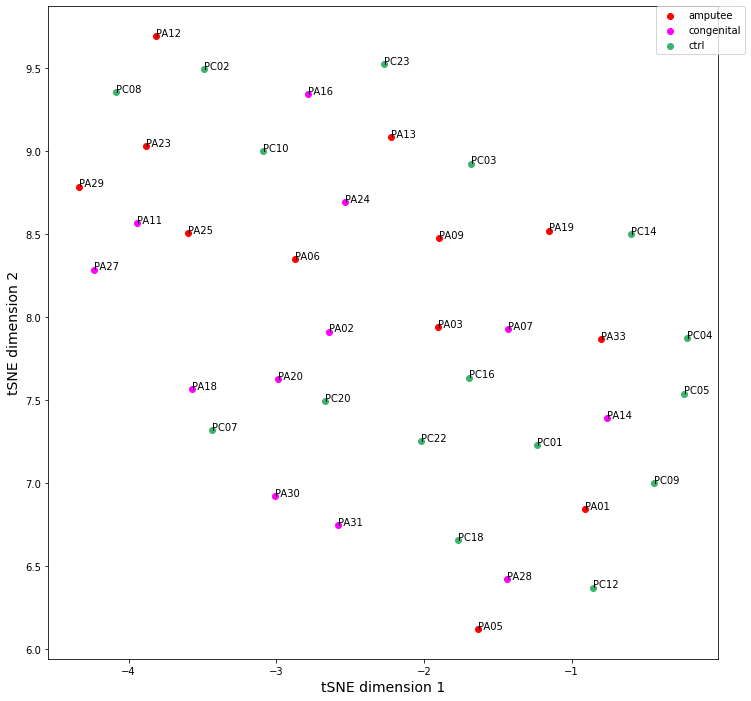

In [230]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_oh)

arr = embedding
color_dict = {'ctrl':'mediumseagreen', 'amputee': 'red', 'congenital':'magenta'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels_oh):
    ix = np.where(labels_oh == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

(array([2., 1., 2., 2., 0., 0., 2., 1., 0., 2.]),
 array([1924. , 1983.6, 2043.2, 2102.8, 2162.4, 2222. , 2281.6, 2341.2,
        2400.8, 2460.4, 2520. ]),
 <BarContainer object of 10 artists>)

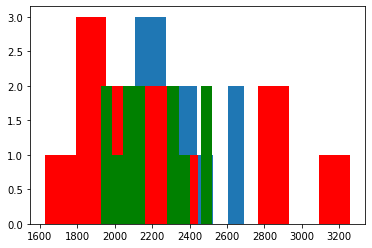

In [231]:
plt.subplot()
plt.hist(losses_oh['ctrl'])
plt.hist(losses_oh['amputee'], color='r')
plt.hist(losses_oh['congenital'], color='g')

In [232]:
recon_oh = {loader_name:[int(results_oh[loader_name][k][2].cpu().detach().numpy()) for k in results_oh[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

(array([2., 1., 0., 4., 0., 0., 2., 1., 0., 2.]),
 array([1511. , 1569.3, 1627.6, 1685.9, 1744.2, 1802.5, 1860.8, 1919.1,
        1977.4, 2035.7, 2094. ]),
 <BarContainer object of 10 artists>)

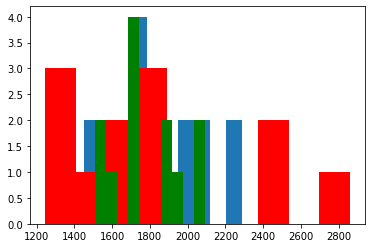

In [233]:
plt.subplot()
plt.hist(recon_oh['ctrl'])
plt.hist(recon_oh['amputee'], color='r')
plt.hist(recon_oh['congenital'], color='g')

### On EUAIMS

In [81]:
labels = pd.read_csv('/neurospin/dico/lguillon/aims_detection/list_subjects.csv')
labels.head()

,ID,group
0,100693509718,1
1,101129844643,1
2,101414625982,2
3,101900205031,2
4,104324981539,2


In [117]:
ctrl = labels[labels['group']==1]
asd = labels[labels['group']==2]
id_ctrl = labels[labels['group']==3]

print(len(asd))

374


In [93]:
np.array(list(asd.ID))

array([101414625982, 101900205031, 104324981539, 107356654390,
       107501679619, 109057020142, 109182897329, 109314636234,
       111297432251, 112152703248, 112250651739, 112353982965,
       113902830642, 116829617056, 118194667229, 123942366629,
       124737109801, 125610027898, 130442593612, 136287182777,
       136536288793, 136851282877, 141031925901, 141793096301,
       149668037941, 150761304327, 152479781222, 155192407573,
       156266822057, 157057245454, 157130105776, 157923026370,
       158414641992, 160054811236, 161926513236, 162000603879,
       166001935037, 169634356147, 171442086801, 175721011373,
       177800559886, 178105062231, 181254963534, 181963433776,
       182470933796, 183456420392, 183962358736, 184577901153,
       186734682586, 195056918956, 195924035910, 196526905399,
       198955934445, 199958815887, 200472210738, 202887019892,
       206523187654, 215510983147, 217861104942, 219811218558,
       220947892915, 230491665566, 230568388344, 234602

In [87]:
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/euaims/crops/SC/no_mask/Rdistmaps/"

distmaps_ctrl = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_ctrl = np.load(os.path.join(data_dir, "sub_id.npy"))
filenames_ctrl = np.array([re.search('\d{12}', filenames_ctrl[k]).group(0) for k in range(len(filenames_ctrl))])

distmaps_asd = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_asd = np.load(os.path.join(data_dir, "sub_id.npy"))

ctrl_list = np.array(list(ctrl.ID))
sorter = np.argsort(filenames_ctrl)
filenames_idx = sorter[np.searchsorted(filenames_ctrl, ctrl_list, sorter=sorter)]
filenames_ctrl = filenames_ctrl[filenames_idx]
distmaps_ctrl = distmaps_ctrl[filenames_idx]

asd_list = np.array(list(asd.ID))
sorter = np.argsort(filenames_asd)
filenames_idx = sorter[np.searchsorted(filenames_asd, asd_list, sorter=sorter)]
filenames_asd = filenames_asd[filenames_idx]
distmaps_asd = distmaps_asd[filenames_idx]

In [41]:
filenames_ctrl = np.load(os.path.join(data_dir, "sub_id.npy"))
ctrl_list = np.array(list(ctrl.group))
sorter = np.argsort(filenames_ctrl)
filenames_idx = sorter[np.searchsorted(filenames_ctrl, ctrl_list, sorter=sorter)]

In [63]:
filenames_ctrl = np.load(os.path.join(data_dir, "sub_id.npy"))

In [88]:
filenames_ctrl

array(['100693509718', '101129844643', '105629441917', '114414660031',
       '115677420583', '118910793563', '118980777980', '123709183152',
       '127510187827', '132297073493', '137282891018', '144831247766',
       '145098407477', '145899409424', '153562611492', '158575356558',
       '159609609900', '160293273948', '166942277585', '169356641606',
       '175673514462', '184436430559', '185048685294', '186014141169',
       '188048341660', '196084871273', '198048766808', '201781530814',
       '204078341146', '209666958265', '220295159492', '224830515714',
       '225718634848', '227007190710', '229219433754', '229951973089',
       '232366221199', '235350958604', '243617148831', '247624139482',
       '250798494359', '254706791256', '257678491670', '265025813179',
       '275900515562', '282946437585', '306895678001', '307860293305',
       '308337626668', '317404610400', '317719510819', '321466110510',
       '322708064836', '327760655614', '328571212222', '331443624857',
      

In [67]:
filenames_ctrl = np.array([re.search('\d{12}', filenames_ctrl[k]).group(0) for k in range(len(filenames_ctrl))])

In [114]:
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/euaims/crops/SC/no_mask/Rdistmaps/"
filenames = np.load(os.path.join(data_dir, "sub_id.npy"))
filenames = np.array([re.search('\d{12}', filenames[k]).group(0) for k in range(len(filenames))])

distmaps_ctrl = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
distmaps_asd = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
distmaps_id_ctrl = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')

ctrl_list = np.array(list(ctrl.ID))
sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, ctrl_list, sorter=sorter)]
filenames_ctrl = filenames[filenames_idx]
distmaps_ctrl = distmaps_ctrl[filenames_idx]


In [118]:
filenames = np.load(os.path.join(data_dir, "sub_id.npy"))
filenames = np.array([re.search('\d{12}', filenames[k]).group(0) for k in range(len(filenames))])

id_ctrl_list = np.array(list(id_ctrl.ID))
sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, id_ctrl_list, sorter=sorter)]
filenames_id_ctrl = filenames[filenames_idx]
distmaps_id_ctrl = distmaps_id_ctrl[filenames_idx]

In [149]:
filenames = np.load(os.path.join(data_dir, "sub_id.npy"))
filenames = np.array([re.search('\d{12}', filenames[k]).group(0) for k in range(len(filenames))])

asd_list = [str(sub) for sub in asd.ID if str(sub) in filenames]
asd_list = np.array(asd_list)
sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, asd_list, sorter=sorter)]
filenames_asd = filenames[filenames_idx]
distmaps_asd = distmaps_asd[filenames_idx]

In [125]:
len(set(filenames)-set(asd_list))

844

In [126]:
filenames

array(['881493409213', '902816250422', '846396767856', '570524772487',
       '107356654390', '841333814207', '825394121668', '487722864717',
       '472209750058', '703515395998', '334813354195', '762580096326',
       '810072092902', '851870964066', '595952676915', '156275255538',
       '277866455055', '795292602017', '948879559425', '567135708905',
       '908722914011', '196526905399', '573074876911', '328571212222',
       '295112357534', '557615482345', '642984348418', '306895678001',
       '963246327235', '826746991440', '423404597109', '765375701704',
       '491998749681', '837417191027', '446120344225', '610444396645',
       '903795797832', '105629441917', '984936877352', '375546130381',
       '141793096301', '224399754295', '294442129240', '968176942032',
       '860225396980', '323195490394', '365711526714', '690625710786',
       '116829617056', '850432151391', '327345752987', '804084059971',
       '340836571839', '474118955267', '955846444559', '972724240119',
      

In [147]:
len([str(sub) for sub in asd.ID if str(sub) in filenames])

354

In [144]:
type(filenames[2])

numpy.str_

In [44]:
sorter[np.searchsorted(filenames_ctrl, ctrl_list, sorter=sorter)]

array([506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 50

In [16]:
filenames_ctrl

array(['sub-881493409213', 'sub-902816250422', 'sub-846396767856',
       'sub-570524772487', 'sub-107356654390', 'sub-841333814207',
       'sub-825394121668', 'sub-487722864717', 'sub-472209750058',
       'sub-703515395998', 'sub-334813354195', 'sub-762580096326',
       'sub-810072092902', 'sub-851870964066', 'sub-595952676915',
       'sub-156275255538', 'sub-277866455055', 'sub-795292602017',
       'sub-948879559425', 'sub-567135708905', 'sub-908722914011',
       'sub-196526905399', 'sub-573074876911', 'sub-328571212222',
       'sub-295112357534', 'sub-557615482345', 'sub-642984348418',
       'sub-306895678001', 'sub-963246327235', 'sub-826746991440',
       'sub-423404597109', 'sub-765375701704', 'sub-491998749681',
       'sub-837417191027', 'sub-446120344225', 'sub-610444396645',
       'sub-903795797832', 'sub-105629441917', 'sub-984936877352',
       'sub-375546130381', 'sub-141793096301', 'sub-224399754295',
       'sub-294442129240', 'sub-968176942032', 'sub-8602253969

In [30]:
labels_oh = pd.read_csv('/neurospin/dico/lguillon/ohbm_22/one_handed_labels.csv')
ctrl = labels_oh[labels_oh['Dominant hand']=='R']
one_handed = labels_oh[labels_oh['Group']!='CTR']
one_handed = labels_oh[labels_oh['Amp. Side']=='L']

amputee = one_handed[one_handed['Group']=='AMP']
cong = one_handed[one_handed['Group']=='CONG']
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/one_handed/crops/SC/no_mask/Rdistmaps/"

distmaps_ctrl = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_ctrl = np.load(os.path.join(data_dir, "sub_id.npy"))

distmaps_amputee = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_amputee = np.load(os.path.join(data_dir, "sub_id.npy"))

distmaps_cong = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_cong = np.load(os.path.join(data_dir, "sub_id.npy"))

ctrl_list = np.array(list(ctrl.SubjID))
sorter = np.argsort(filenames_ctrl)
filenames_idx = sorter[np.searchsorted(filenames_ctrl, ctrl_list, sorter=sorter)]
filenames_ctrl = filenames_ctrl[filenames_idx]
distmaps_ctrl = distmaps_ctrl[filenames_idx]

In [34]:
ctrl_list

array(['PC01', 'PC02', 'PC03', 'PC04', 'PC05', 'PC07', 'PC08', 'PC09',
       'PC10', 'PC12', 'PC14', 'PC16', 'PC18', 'PC20', 'PC22', 'PC23'],
      dtype='<U4')

In [249]:
distmaps_asd.shape

(374, 78, 63, 88, 1)

In [239]:
subset_ctrl = SkeletonDataset(dataframe=distmaps_ctrl,
                         filenames=filenames_ctrl,
                         data_transforms=False)

ctrl_loader = torch.utils.data.DataLoader(
               subset_ctrl,
               batch_size=1,
               num_workers=1,
               shuffle=False) 

subset_asd = SkeletonDataset(dataframe=distmaps_asd,
                         filenames=filenames_asd,
                         data_transforms=False)

asd_loader = torch.utils.data.DataLoader(
               subset_asd,
               batch_size=1,
               num_workers=1,
               shuffle=False) 

dico_set_loaders = {'ctrl': ctrl_loader, 'asd': asd_loader}


In [253]:
dico_set_loaders = {'ctrl': scint_loader, 'asd': asd_loader}

In [254]:
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=50, depth=3)

results_aims = tester.test()

losses_aims = {loader_name:[int(results_aims[loader_name][k][0].cpu().detach().numpy()) for k in results_aims[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
encoded_aims = {loader_name:[results_aims[loader_name][k][1] for k in results_aims[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

ctrl
asd


In [202]:
df_encoded_aims = pd.DataFrame()
df_encoded_aims['latent'] = encoded_aims['ctrl'] + encoded_aims['asd']
df_encoded_aims['Group'] = ['ctrl' for k in range(len(losses_aims['ctrl']))] + ['asd' for k in range(len(losses_aims['asd']))]

subjects_name = list(filenames_ctrl) + list(filenames_asd)

KeyError: 'asd'

In [259]:
results['scint'].keys()

dict_keys(['138231', '510225', '159946', '140319', '212419', '199251', '111009'])

In [450]:
losses['scint']

[3152, 3376, 3060, 2545, 3610, 3016, 3605]

In [216]:
from scipy import stats

In [452]:
print(np.std(losses['hcp']))
print(np.std(losses['scint']))

330.64370914928963
347.9944287614093


In [187]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
for k in range(200, 207):
    print(neigh.kneighbors(np.expand_dims(X[k], axis=0)))

(array([[ 0.        , 11.69054825, 12.00801633, 13.4761403 ]]), array([[200, 206, 210, 224]]))
(array([[ 0.        , 13.45366735, 13.96529384, 14.17247194]]), array([[201, 215, 208, 214]]))
(array([[ 0.        , 14.1431712 , 14.67249479, 14.83832237]]), array([[202, 218, 228, 247]]))
(array([[ 0.        , 13.09613229, 13.41196201, 13.99237086]]), array([[203, 221, 215, 217]]))
(array([[ 0.        , 14.99152268, 15.96027309, 16.04859976]]), array([[204,  28, 127, 215]]))
(array([[ 0.        , 13.33081389, 13.67092942, 13.76308412]]), array([[205, 210, 208, 226]]))
(array([[ 0.        , 11.69054825, 13.38221995, 13.43525141]]), array([[206, 200, 210, 224]]))


In [188]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
for k in range(200, 207):
    print(neigh.kneighbors(np.expand_dims(X[k], axis=0)))

(array([[ 0.        , 11.69054825, 12.00801633, 13.4761403 ]]), array([[200, 206, 210, 224]]))
(array([[ 0.        , 13.45366735, 13.96529384, 14.17247194]]), array([[201, 215, 208, 214]]))
(array([[ 0.        , 14.1431712 , 14.67249479, 14.83832237]]), array([[202, 218, 228, 247]]))
(array([[ 0.        , 13.09613229, 13.41196201, 13.99237086]]), array([[203, 221, 215, 217]]))
(array([[ 0.        , 14.99152268, 15.96027309, 16.04859976]]), array([[204,  28, 127, 215]]))
(array([[ 0.        , 13.33081389, 13.67092942, 13.76308412]]), array([[205, 210, 208, 226]]))
(array([[ 0.        , 11.69054825, 13.38221995, 13.43525141]]), array([[206, 200, 210, 224]]))


In [390]:
sub['hcp'][49]

168139

In [280]:
filenames_scint

array(['138231', '510225', '159946', '140319', '212419', '199251',
       '111009'], dtype='<U6')

### Study of reconstruction error as anomaly score

In [394]:
idx = np.where(np.array(losses['hcp'])>3000)

In [401]:
sub['hcp'][idx]

array([887373, 704238, 679770, 124422, 872158, 942658, 168038, 802844,
       116221, 100206, 172534, 329440, 180937, 965367, 351938, 185038,
       145632, 199958, 121416, 731140, 135730, 104012, 117122, 176239,
       123824, 275645, 189450, 167440, 891667, 139839, 120010, 510326,
       456346, 573249, 175035, 211720])

In [464]:
enc = encoded['hcp'][10]

In [417]:
enc.shape

(20,)

In [465]:
arr_out = []
values = []

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

# arr_out = np.array(arr_out)
# np.save(f"/volatile/arr_out.npy", arr_out)
# np.save('/volatile/arr_label.npy', np.array(values))

In [466]:
out[out>0.5] = 1
out[out<=0.5] = 0

In [467]:
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/volatile/bucket_test.bck")